## Libraries

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Load the MNIST dataset

In [2]:
mnist = fetch_openml("mnist_784", as_frame=False, parser='liac-arff')
data = mnist.data / 255.0  # Normalize pixel values to [0, 1]

## K-Means

In [3]:
# Initialize K-means with 40 clusters
kmeans_40 = KMeans(n_clusters=40, random_state=0, n_init=10)
# Fit K-means on the data
kmeans_40.fit(data)
# Get the centroids
centroids_40 = kmeans_40.cluster_centers_

## Plot K-Means Centroids for Visualisation


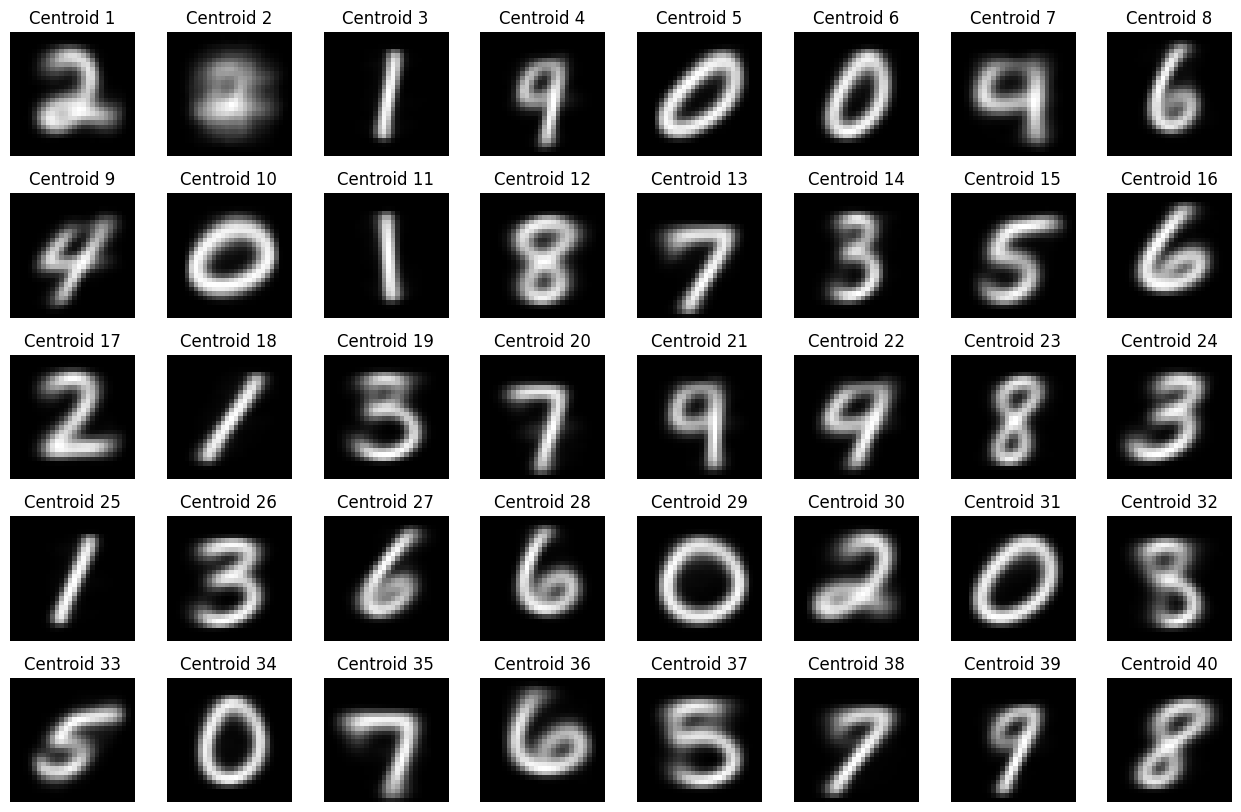

In [4]:
def plot_centroids(centroids):
    num_centroids = len(centroids)
    num_per_row = 8  # Define the number of centroids per row
    num_rows = num_centroids // num_per_row + (1 if num_centroids % num_per_row != 0 else 0)
    
    fig, ax = plt.subplots(num_rows, num_per_row, figsize=(16, 2*num_rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    
    for i in range(num_rows):
        for j in range(num_per_row):
            idx = i * num_per_row + j
            if idx < num_centroids:
                ax[i, j].imshow(centroids[idx].reshape(28, 28), cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f'Centroid {idx + 1}')

    plt.show()
    
plot_centroids(centroids_40)

## Split the data into Train and Test

In [5]:
from sklearn.model_selection import train_test_split

target = mnist.target.astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)



## Compute the activation matrix Fi for training data

In [6]:
# Compute the hidden layer activations
def calculate_activations(data, centroids):
    N = data.shape[0]
    M = centroids.shape[0]
    Fi = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            Fi[i, j] = np.exp(-np.linalg.norm(data[i] - centroids[j]) ** 2)
    return Fi

# Calculate activations for training data
Fi_train = calculate_activations(X_train, centroids_40)

## One-Hot Encoding for Training Labels

In [7]:
# Step 2: Convert y_train to one-hot encoding
Y = np.zeros((len(y_train), 10))
for i in range(len(y_train)):
    Y[i, y_train[i]] = 1
    
Y_test = np.zeros((len(y_test), 10))
for i in range(len(y_test)):
    Y_test[i, y_test[i]] = 1

## Pseudo-inverse method to calculate weights

In [8]:
# Step 3: Calculate the pseudo-inverse
pseudo_inv = np.linalg.pinv(Fi_train)

weights = np.dot(pseudo_inv, Y).T

## Plot the weight heat map

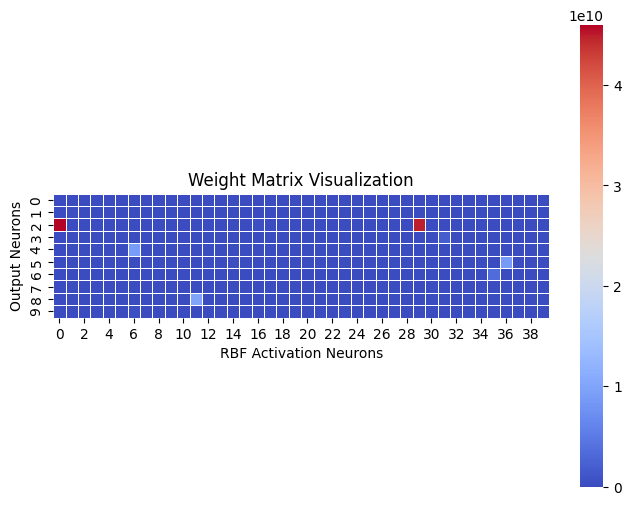

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(weights, cmap='coolwarm', linewidths=0.5, square=True)
plt.xlabel('RBF Activation Neurons')
plt.ylabel('Output Neurons')
plt.title('Weight Matrix Visualization')
plt.show()


## Calculate test activations

In [10]:
Fi_test = calculate_activations(X_test, centroids_40)

## Get outputs from weights and calculate the confusion matrix

[5 0 4 ... 4 5 6]
Confusion Matrix:
[[1204   20   13    7    1   36   48    1   12    1]
 [   0 1541    7   20    0    1    3    0   24    4]
 [   1  115 1175   30    7    3    9    5   35    0]
 [   3   48   38 1086    1  152    1    3   87   14]
 [   0  127   15    8  551    1   18    1    1  573]
 [   8   77    4  255   12  866   12    2   29    8]
 [  12   77    1    5    5   10 1284    0    2    0]
 [   2  121   24    5   41    7    0 1047   10  246]
 [   1   59   17  189    6   93    7    3  972   10]
 [   4   63    4   28  267   11    2   56   20  965]]


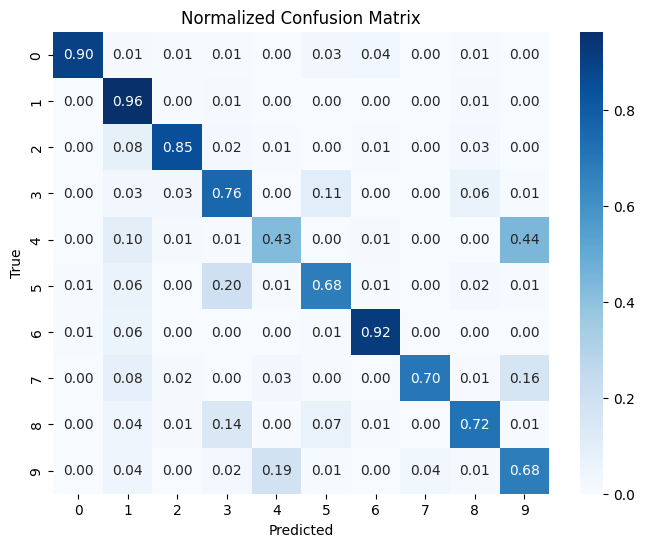

In [11]:
from sklearn.metrics import confusion_matrix

print(target)

# Predict classes for the test set using the trained weights
scores = np.dot(Fi_test, weights.T)
y_test_pred = np.argmax(scores, axis=1)

# Create a confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_mat)

# Normalize confusion matrix
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm, annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

## Print the classification report

In [12]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_test, y_test_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1343
           1       0.69      0.96      0.80      1600
           2       0.91      0.85      0.88      1380
           3       0.67      0.76      0.71      1433
           4       0.62      0.43      0.50      1295
           5       0.73      0.68      0.71      1273
           6       0.93      0.92      0.92      1396
           7       0.94      0.70      0.80      1503
           8       0.82      0.72      0.76      1357
           9       0.53      0.68      0.60      1420

    accuracy                           0.76     14000
   macro avg       0.78      0.76      0.76     14000
weighted avg       0.78      0.76      0.76     14000



# 2. Use of SGD

Epoch 1/30
1750/1750 [==============================] - 2s 972us/step - loss: 6.4909 - accuracy: 0.8809 - val_loss: 0.3287 - val_accuracy: 0.9161
Epoch 2/30
1750/1750 [==============================] - 2s 891us/step - loss: 0.2678 - accuracy: 0.9290 - val_loss: 0.2636 - val_accuracy: 0.9344
Epoch 3/30
1750/1750 [==============================] - 2s 896us/step - loss: 0.2163 - accuracy: 0.9406 - val_loss: 0.2304 - val_accuracy: 0.9403
Epoch 4/30
1750/1750 [==============================] - 2s 909us/step - loss: 0.1858 - accuracy: 0.9488 - val_loss: 0.2171 - val_accuracy: 0.9425
Epoch 5/30
1750/1750 [==============================] - 2s 914us/step - loss: 0.1653 - accuracy: 0.9530 - val_loss: 0.1988 - val_accuracy: 0.9469
Epoch 6/30
1750/1750 [==============================] - 2s 910us/step - loss: 0.1495 - accuracy: 0.9564 - val_loss: 0.1920 - val_accuracy: 0.9476
Epoch 7/30
1750/1750 [==============================] - 2s 912us/step - loss: 0.1386 - accuracy: 0.9594 - val_loss: 0.1839 -

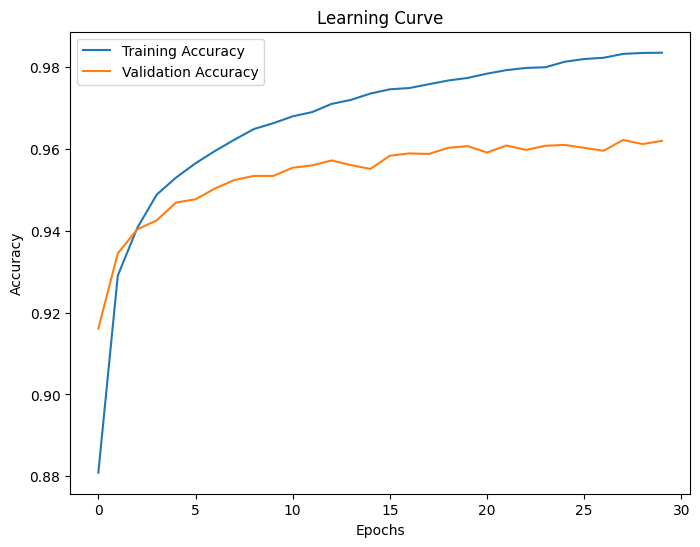

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from keras.optimizers import SGD


# Assuming centroids_40 and weights are computed as per the previous steps

# Create RBF network architecture without biases
model = Sequential()
# model.add(Dense(40, input_shape=(784,), activation='relu'))
model.add(Dense(40, input_shape=(784,), activation='relu', weights=[centroids_40.T, np.zeros(40)]))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.1, momentum=0.9)

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming X_train and Y are defined)
history = model.fit(X_train, Y, epochs=30, batch_size=32, validation_data=(X_test, Y_test))

# 1) Learning curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




438/438 [==============================] - 0s 596us/step


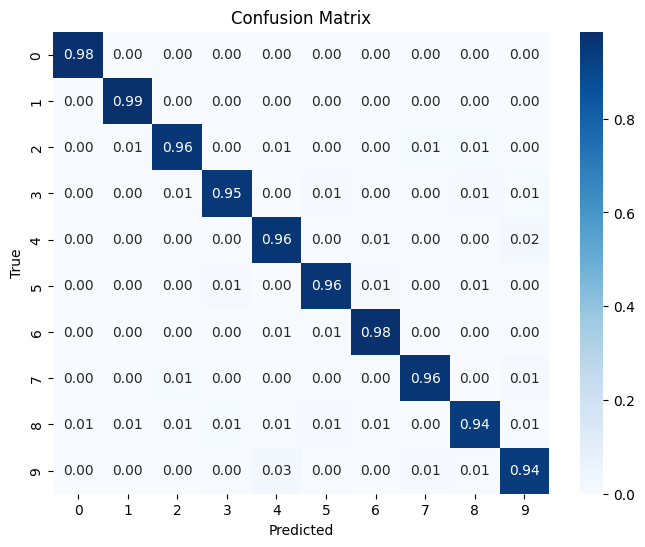

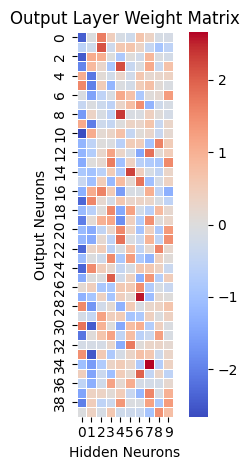

In [17]:
# 2) Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(np.argmax(Y_test, axis=1), y_pred_classes)

conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm, annot=True, cmap='Blues', fmt='.2f', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3) Weight heat map for both layers
weights_output = model.layers[1].get_weights()[0]

plt.subplot(1, 2, 2)
sns.heatmap(weights_output, cmap='coolwarm', linewidths=0.5, square=True)
plt.xlabel('Hidden Neurons')
plt.ylabel('Output Neurons')
plt.title('Output Layer Weight Matrix')

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Assuming y_test and y_pred are the true labels and predicted labels, respectively
report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1343
           1       0.98      0.99      0.98      1600
           2       0.96      0.96      0.96      1380
           3       0.97      0.95      0.96      1433
           4       0.94      0.96      0.95      1295
           5       0.95      0.96      0.96      1273
           6       0.97      0.98      0.97      1396
           7       0.97      0.96      0.96      1503
           8       0.95      0.94      0.95      1357
           9       0.94      0.94      0.94      1420

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000

